In [169]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

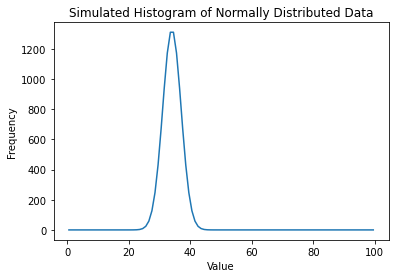

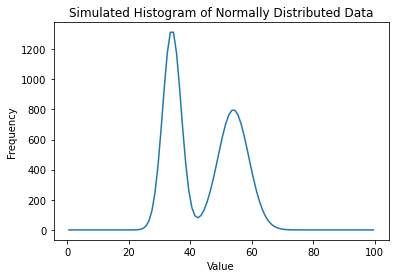

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_normal_histogram(mu, sigma, n_bins, n_points, range_min, range_max):
    # Define the range of the histogram
    bins = np.linspace(range_min, range_max, n_bins+1)
    
    # Compute the center of bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Calculate the PDF for each bin center
    pdf_values = norm.pdf(bin_centers, loc=mu[0], scale=sigma[0])
    
    # Scale the PDF values to simulate 'n_points' data points
    bin_widths = np.diff(bins)
    histogram_values = pdf_values * n_points * bin_widths
    
    return bin_centers, histogram_values

def simulate_bimodal_histogram(mu, sigma, n_bins, n_points, range_min, range_max):
    # Define the range of the histogram
    bins = np.linspace(range_min, range_max, n_bins+1)
    
    # Compute the center of bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Calculate the PDF for each bin center
    pdf_values1 = norm.pdf(bin_centers, loc=mu[0], scale=sigma[0])
    pdf_values2 = norm.pdf(bin_centers, loc=mu[1], scale=sigma[1])
    
    # Scale the PDF values to simulate 'n_points' data points
    bin_widths = np.diff(bins)
    histogram_values = (pdf_values1 + pdf_values2) * n_points * bin_widths
    
    return bin_centers, histogram_values

# Parameters for the histogram
mu = [34]       # Mean of the distribution
sigma = [3]     # Standard deviation of the distribution
n_bins = 100   # Number of bins
n_points = 10000  # Number of points you would simulate
range_min = 0
range_max = 100

# Generate the histogram values
bin_centers, histogram_values = simulate_normal_histogram(mu, sigma, n_bins, n_points, range_min, range_max)

# Plotting the simulated histogram
plt.plot(bin_centers, histogram_values)
plt.title('Simulated Histogram of Normally Distributed Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

mu = [34, 54]       # Mean of the distribution
sigma = [3, 5]     # Standard deviation of the distribution
n_bins = 100   # Number of bins
n_points = 10000  # Number of points you would simulate
range_min = 0
range_max = 100

# Generate the histogram values
bin_centers, histogram_values = simulate_bimodal_histogram(mu, sigma, n_bins, n_points, range_min, range_max)

# Plotting the simulated histogram
plt.plot(bin_centers, histogram_values)
plt.title('Simulated Histogram of Normally Distributed Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [25]:
n_bins = 100   # Number of bins
range_min = 0
range_max = 100

data = np.empty((0, 100))
label = []

for i in range(1000):
    coin = np.random.randint(2)
    n_points = np.random.randint(10000, 20000)

    sigma = np.random.rand(coin+1)*3+2
    
    if coin:
        mu = np.full(2, np.random.rand()*70+15) + np.array([-np.random.rand()*2.5*np.mean(sigma), np.random.rand()*2.5*np.mean(sigma)])
    else:
        mu = [np.random.rand()*70+15]
        
    if coin:
        bin_centers, histogram_values = simulate_bimodal_histogram(mu, sigma, n_bins, n_points, range_min, range_max)  
        
        #print(np.diff(histogram_values[np.argmax(histogram_values)+1:]) < 0)
        #print(np.diff(histogram_values[:np.argmax(histogram_values)]) > 0)
        
        if (np.all(np.diff(histogram_values[np.argmax(histogram_values)+1:]) < 0) and 
            np.all(np.diff(histogram_values[:np.argmax(histogram_values)]) > 0)):
            label.append(1)
        else:
            label.append(2)
    else:
        bin_centers, histogram_values = simulate_normal_histogram(mu, sigma, n_bins, n_points, range_min, range_max)
        label.append(0)
        
    histogram_values += np.random.normal(loc=0.0, scale=20, size=len(histogram_values))
        
    #plt.plot(bin_centers, histogram_values)
    #plt.title(label[-1])
    #plt.xlabel('Value')
    #plt.ylabel('Frequency')
    #plt.show()
        
    data = np.vstack((data, histogram_values))
    
data = np.expand_dims(data, axis=-1)
label = np.array(label)

print(data.shape)
print(label.shape)

(1000, 100, 1)
(1000,)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.metrics import AUC

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 98, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1472)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [27]:
history = model.fit(
    data, label,        # Training data and labels
    epochs=200,               # Number of epochs to train for
    batch_size=32,           # Number of samples per gradient update
    validation_split=0.2,    # Fraction of the data to use as validation data
    verbose=1                # Show progress
)

Epoch 1/200
25/25 [==============================] - 2s 16ms/step - loss: 21.1731 - accuracy: 0.4412 - val_loss: 5.3831 - val_accuracy: 0.6550
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 3.4656 - accuracy: 0.7325 - val_loss: 3.7283 - val_accuracy: 0.6950
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 1.4685 - accuracy: 0.8075 - val_loss: 2.7536 - val_accuracy: 0.7550
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 0.8568 - accuracy: 0.8662 - val_loss: 1.6154 - val_accuracy: 0.8100
Epoch 5/200
25/25 [==============================] - 0s 6ms/step - loss: 0.3785 - accuracy: 0.9025 - val_loss: 1.5431 - val_accuracy: 0.8450
Epoch 6/200
25/25 [==============================] - 0s 6ms/step - loss: 0.1847 - accuracy: 0.9463 - val_loss: 1.6025 - val_accuracy: 0.8150
Epoch 7/200
25/25 [==============================] - 0s 6ms/step - loss: 0.1542 - accuracy: 0.9525 - val_loss: 1.4417 - val_accuracy: 0.8350
Epoch 8/200

Epoch 58/200
25/25 [==============================] - 0s 6ms/step - loss: 2.5536e-04 - accuracy: 1.0000 - val_loss: 1.4187 - val_accuracy: 0.8550
Epoch 59/200
25/25 [==============================] - 0s 6ms/step - loss: 2.5271e-04 - accuracy: 1.0000 - val_loss: 1.4232 - val_accuracy: 0.8550
Epoch 60/200
25/25 [==============================] - 0s 6ms/step - loss: 2.4419e-04 - accuracy: 1.0000 - val_loss: 1.4232 - val_accuracy: 0.8550
Epoch 61/200
25/25 [==============================] - 0s 6ms/step - loss: 2.3754e-04 - accuracy: 1.0000 - val_loss: 1.4238 - val_accuracy: 0.8550
Epoch 62/200
25/25 [==============================] - 0s 6ms/step - loss: 2.3164e-04 - accuracy: 1.0000 - val_loss: 1.4247 - val_accuracy: 0.8550
Epoch 63/200
25/25 [==============================] - 0s 6ms/step - loss: 2.2662e-04 - accuracy: 1.0000 - val_loss: 1.4246 - val_accuracy: 0.8550
Epoch 64/200
25/25 [==============================] - 0s 7ms/step - loss: 2.1957e-04 - accuracy: 1.0000 - val_loss: 1.4291 -

25/25 [==============================] - 0s 6ms/step - loss: 7.9175e-05 - accuracy: 1.0000 - val_loss: 1.4607 - val_accuracy: 0.8600
Epoch 115/200
25/25 [==============================] - 0s 6ms/step - loss: 7.7862e-05 - accuracy: 1.0000 - val_loss: 1.4625 - val_accuracy: 0.8550
Epoch 116/200
25/25 [==============================] - 0s 5ms/step - loss: 7.6581e-05 - accuracy: 1.0000 - val_loss: 1.4641 - val_accuracy: 0.8600
Epoch 117/200
25/25 [==============================] - 0s 6ms/step - loss: 7.6265e-05 - accuracy: 1.0000 - val_loss: 1.4639 - val_accuracy: 0.8600
Epoch 118/200
25/25 [==============================] - 0s 6ms/step - loss: 7.3576e-05 - accuracy: 1.0000 - val_loss: 1.4669 - val_accuracy: 0.8600
Epoch 119/200
25/25 [==============================] - 0s 6ms/step - loss: 7.2477e-05 - accuracy: 1.0000 - val_loss: 1.4644 - val_accuracy: 0.8600
Epoch 120/200
25/25 [==============================] - 0s 6ms/step - loss: 7.1298e-05 - accuracy: 1.0000 - val_loss: 1.4665 - val_ac

Epoch 170/200
25/25 [==============================] - 0s 7ms/step - loss: 3.2183e-05 - accuracy: 1.0000 - val_loss: 1.4978 - val_accuracy: 0.8600
Epoch 171/200
25/25 [==============================] - 0s 7ms/step - loss: 3.1809e-05 - accuracy: 1.0000 - val_loss: 1.4961 - val_accuracy: 0.8600
Epoch 172/200
25/25 [==============================] - 0s 8ms/step - loss: 3.1309e-05 - accuracy: 1.0000 - val_loss: 1.4978 - val_accuracy: 0.8600
Epoch 173/200
25/25 [==============================] - 0s 7ms/step - loss: 3.0847e-05 - accuracy: 1.0000 - val_loss: 1.5019 - val_accuracy: 0.8600
Epoch 174/200
25/25 [==============================] - 0s 8ms/step - loss: 3.0927e-05 - accuracy: 1.0000 - val_loss: 1.5017 - val_accuracy: 0.8600
Epoch 175/200
25/25 [==============================] - 0s 7ms/step - loss: 3.0009e-05 - accuracy: 1.0000 - val_loss: 1.4984 - val_accuracy: 0.8600
Epoch 176/200
25/25 [==============================] - 0s 7ms/step - loss: 2.9530e-05 - accuracy: 1.0000 - val_loss: 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


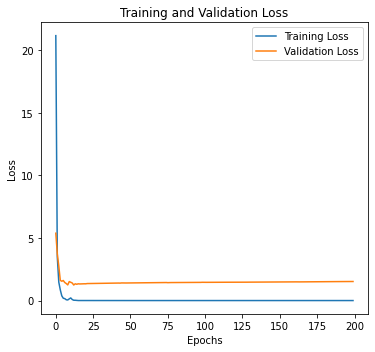

In [28]:
print(history.history.keys())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

"""
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
"""

plt.tight_layout()
plt.show()

In [32]:
data_real = np.empty((0, 100))

for i in range(100):
    coin = np.random.randint(2)
    n_points = np.random.randint(10000, 20000)

    sigma = np.random.rand(coin+1)*3+2
    
    if coin:
        mu = np.full(2, np.random.rand()*70+15) + np.array([-np.random.rand()*2.5*np.mean(sigma), np.random.rand()*2.5*np.mean(sigma)])
    else:
        mu = [np.random.rand()*70+15]
        
    if coin:
        bin_centers, histogram_values = simulate_bimodal_histogram(mu, sigma, n_bins, n_points, range_min, range_max)
    else:
        bin_centers, histogram_values = simulate_normal_histogram(mu, sigma, n_bins, n_points, range_min, range_max)
        
    histogram_values += np.random.normal(loc=0.0, scale=20, size=len(histogram_values))
        
    data_real = np.vstack((data_real, histogram_values))
    
data_real = np.expand_dims(data_real, axis=-1)

predicted_probabilities = model.predict(data_real)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

print(predicted_labels)

4/4 [==============================] - 0s 3ms/step
[2 2 1 1 2 0 2 0 0 2 2 2 0 2 0 2 0 0 2 0 0 0 0 0 0 1 0 1 1 0 1 0 2 0 0 0 1
 2 2 0 2 0 0 0 0 0 0 1 0 2 2 0 0 2 0 0 0 0 0 2 1 0 0 0 0 0 0 0 1 0 1 2 2 0
 2 1 0 2 0 2 2 2 0 2 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 0]


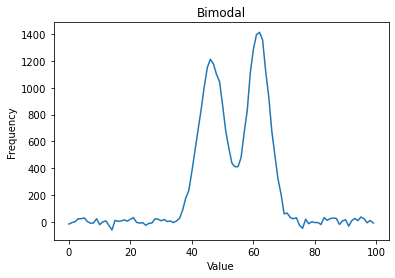

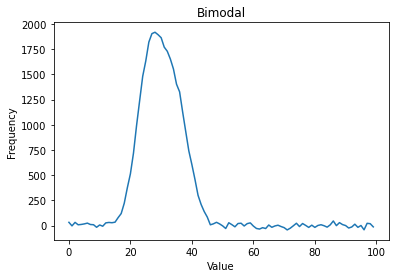

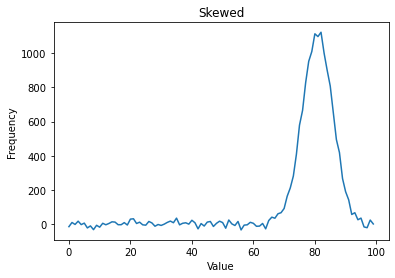

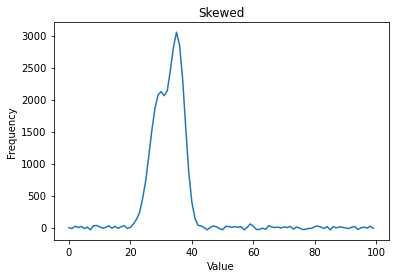

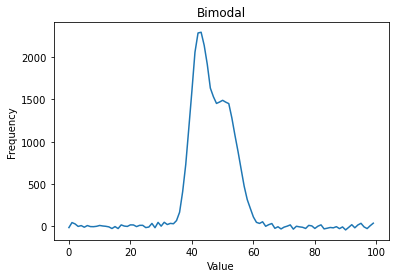

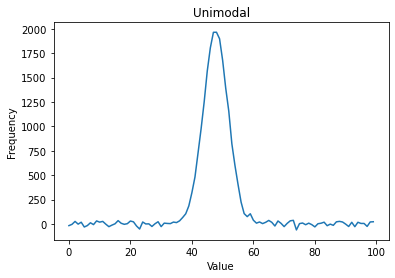

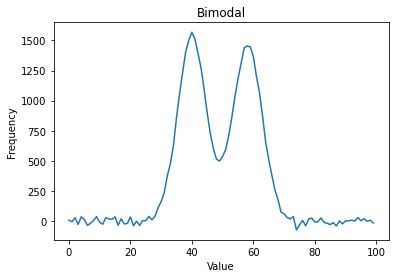

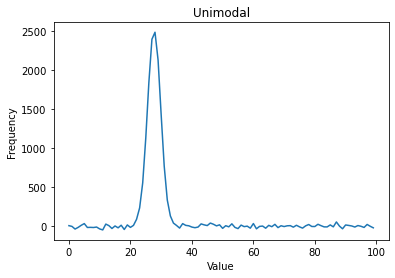

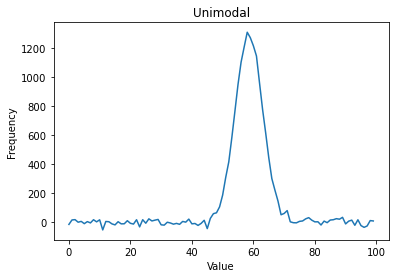

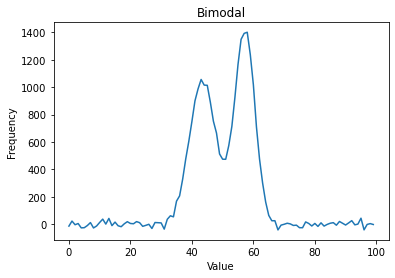

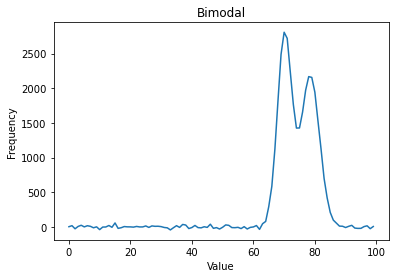

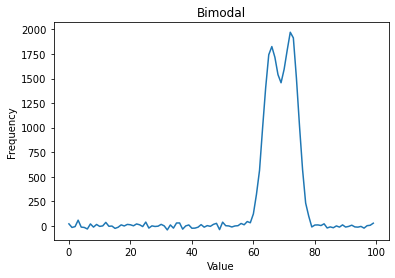

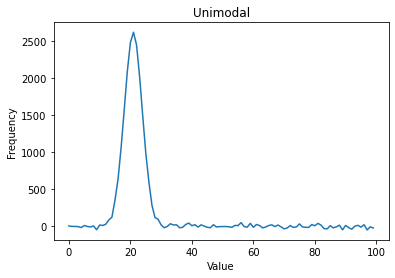

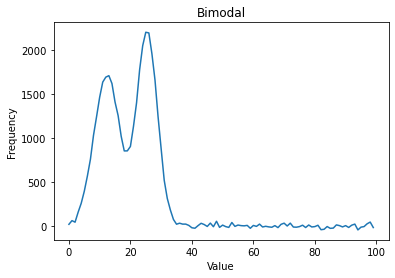

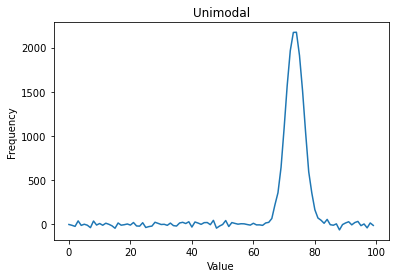

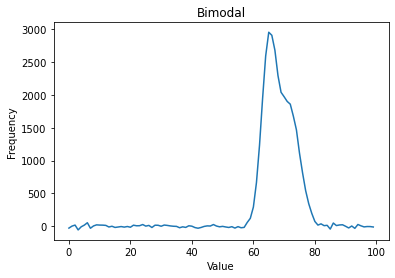

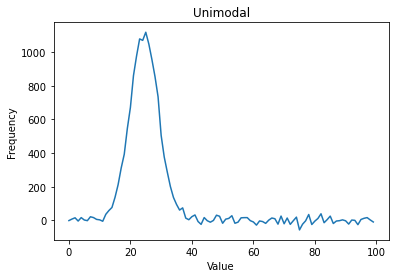

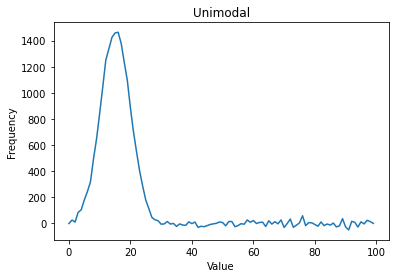

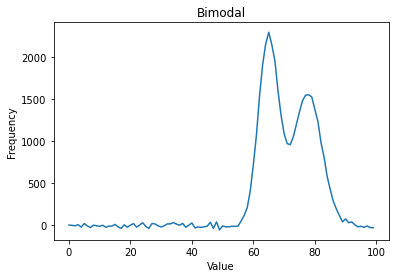

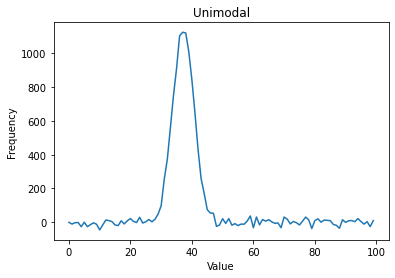

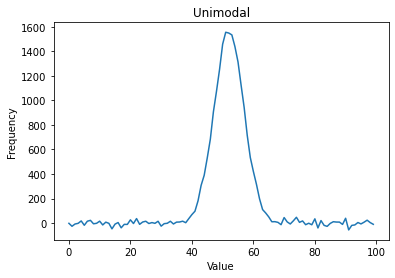

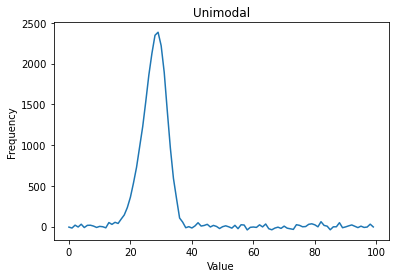

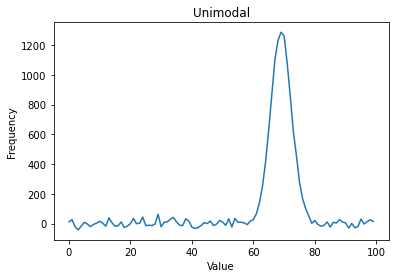

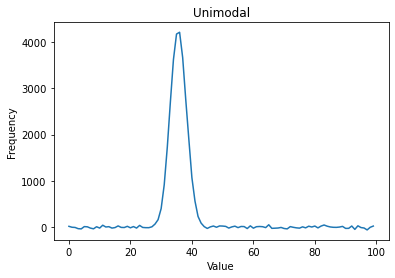

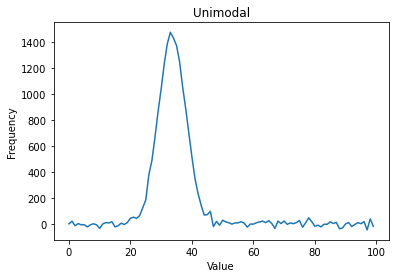

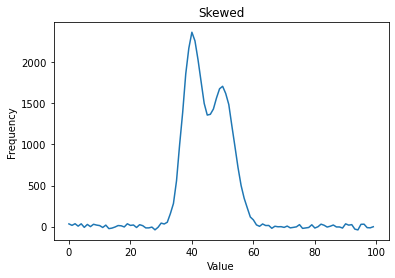

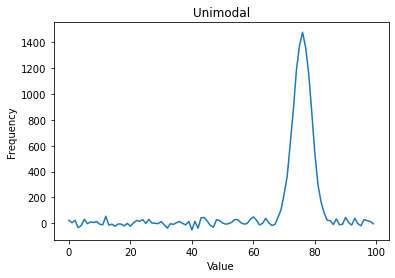

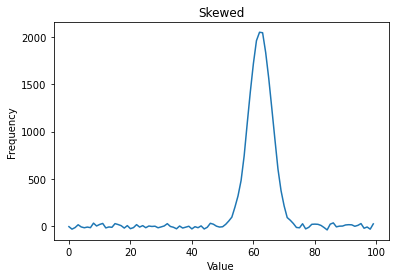

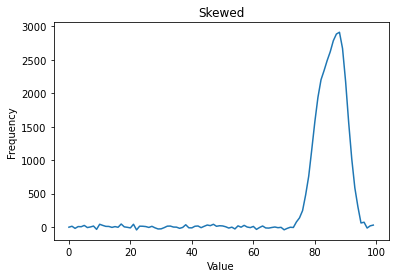

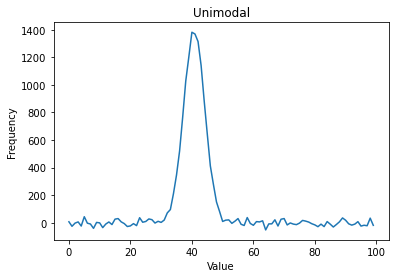

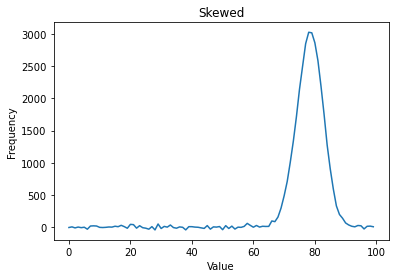

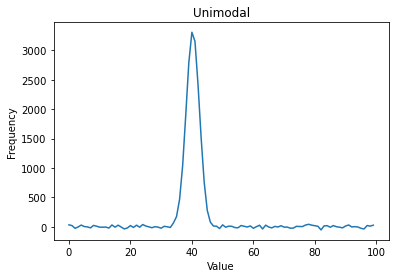

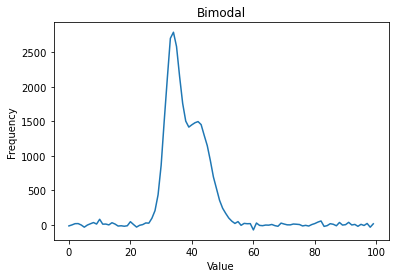

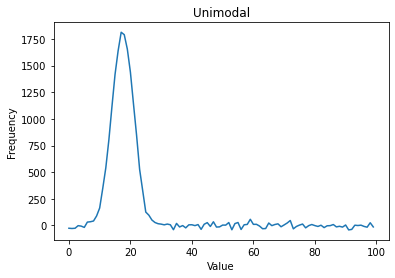

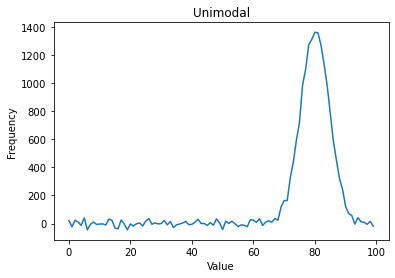

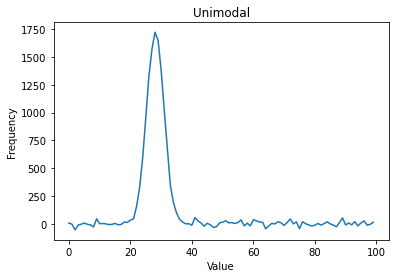

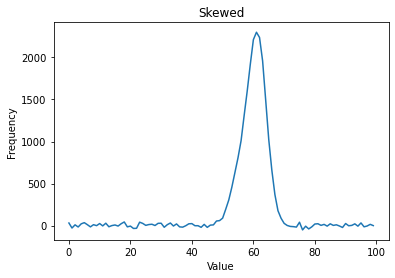

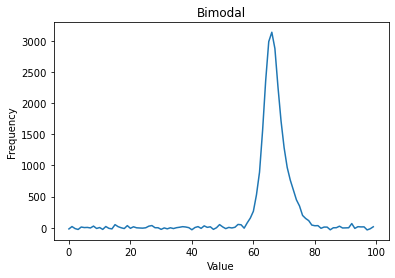

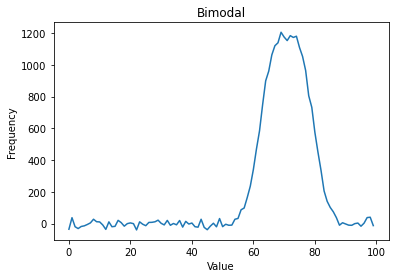

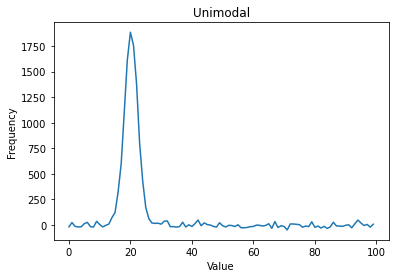

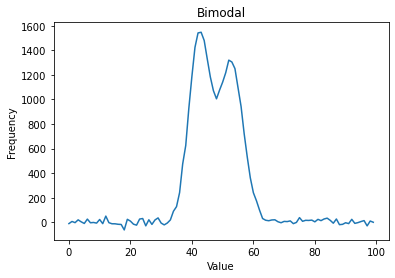

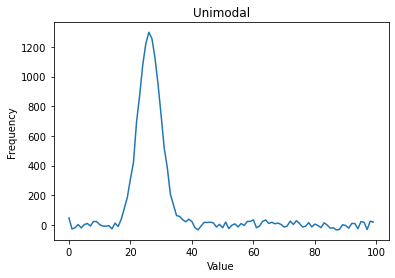

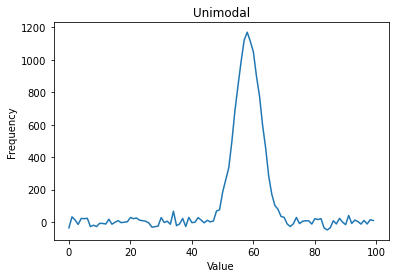

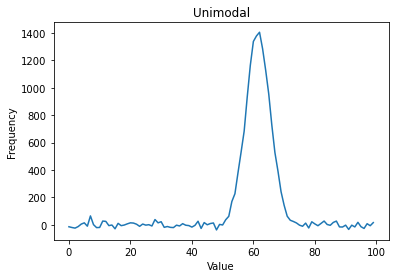

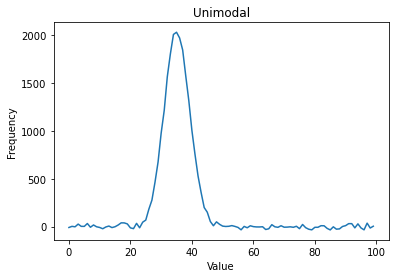

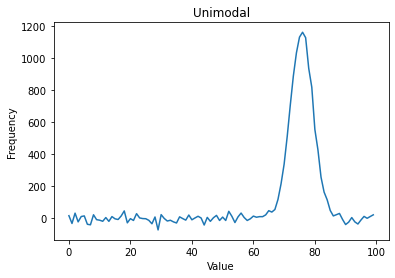

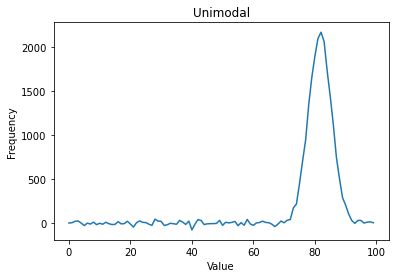

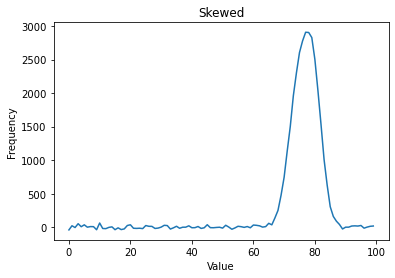

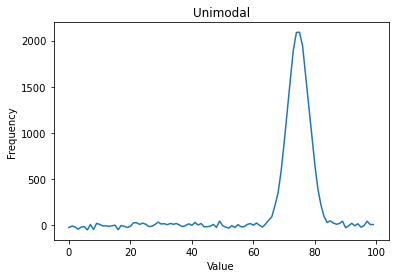

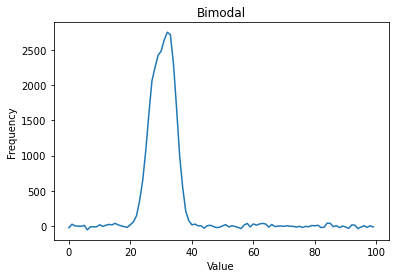

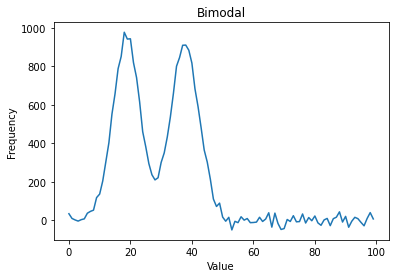

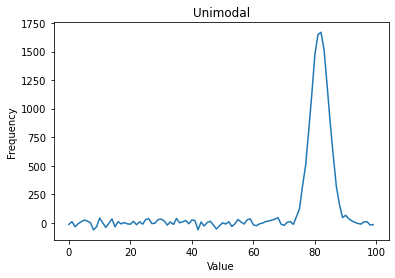

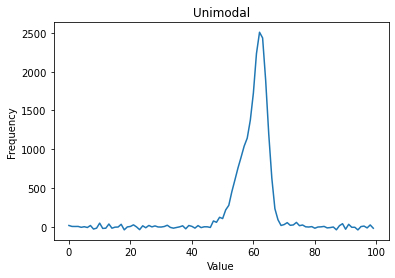

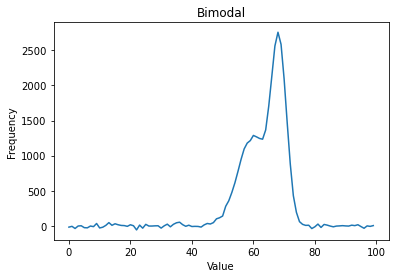

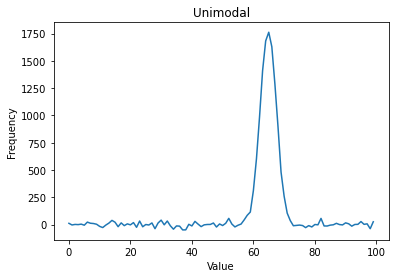

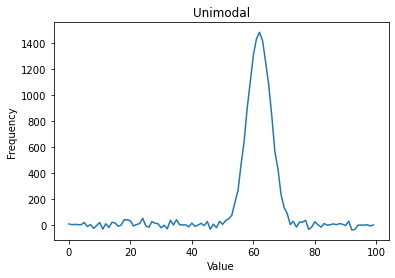

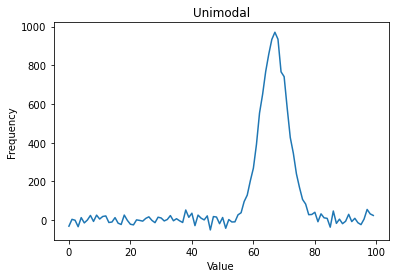

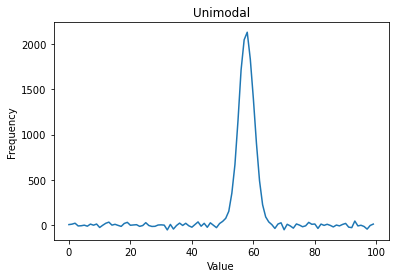

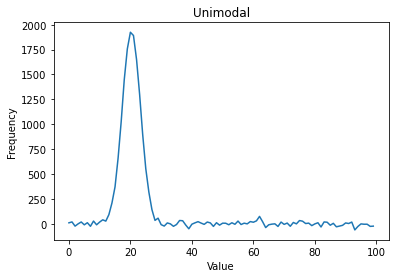

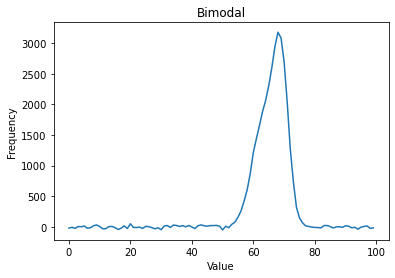

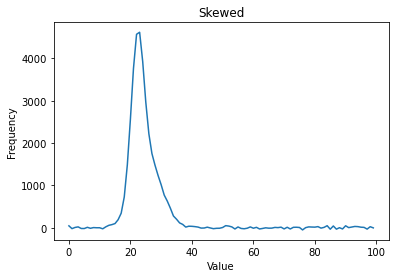

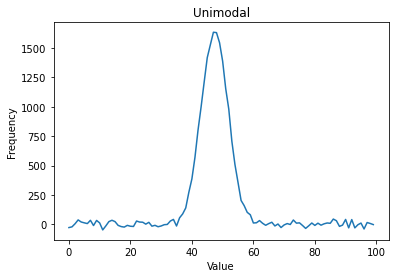

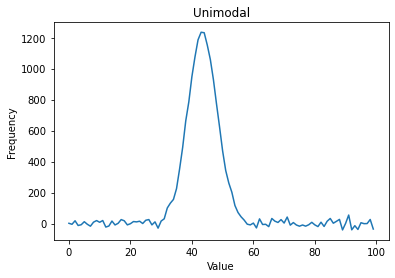

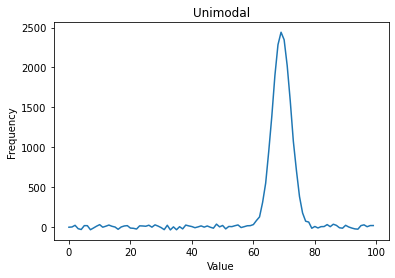

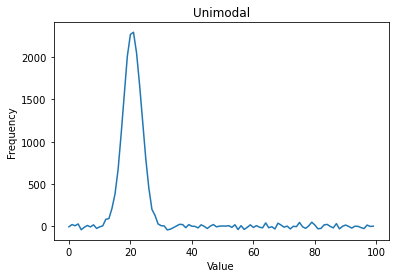

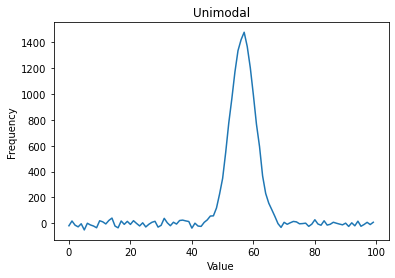

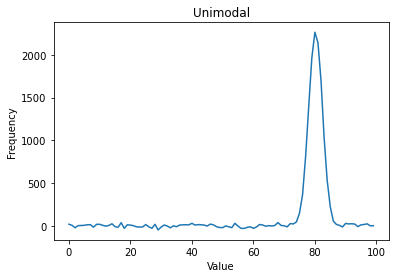

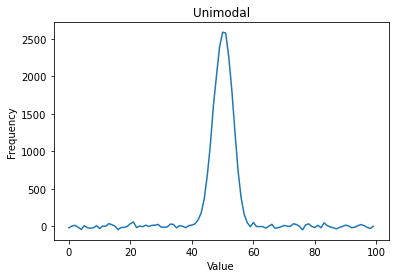

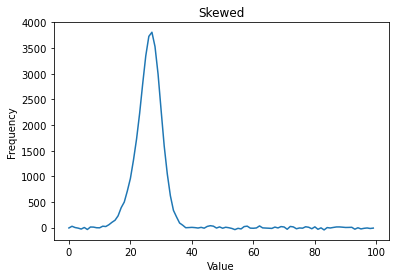

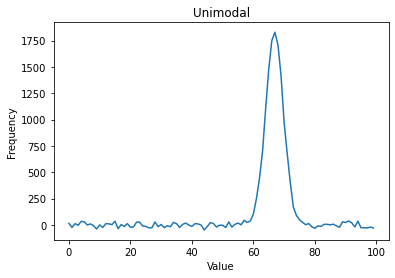

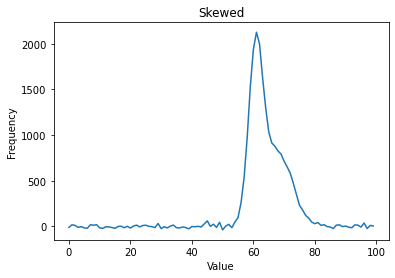

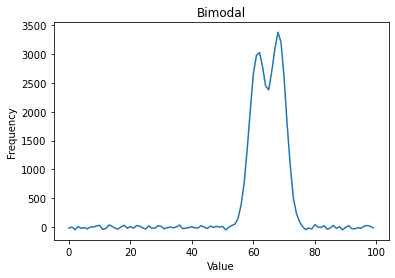

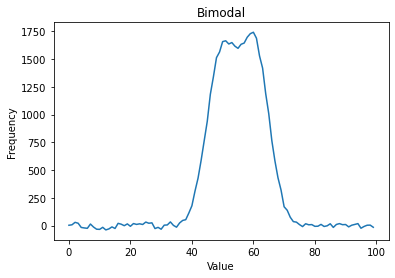

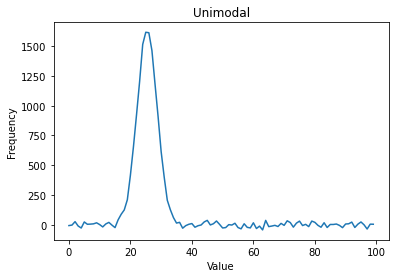

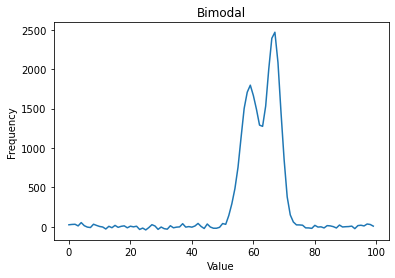

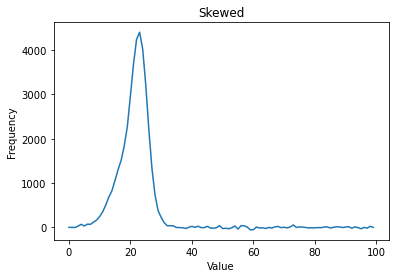

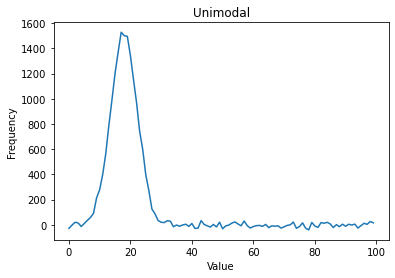

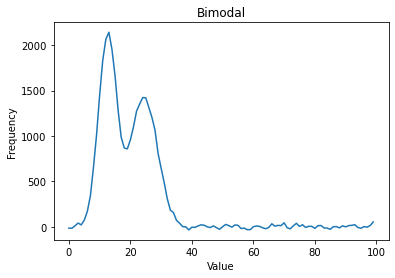

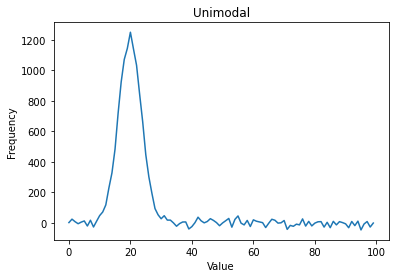

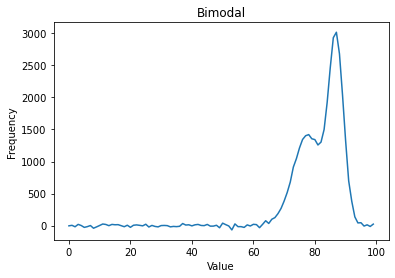

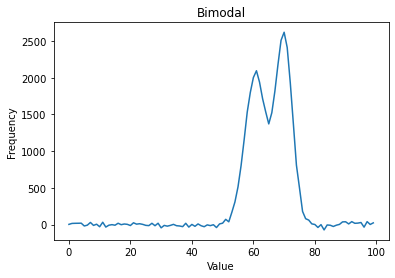

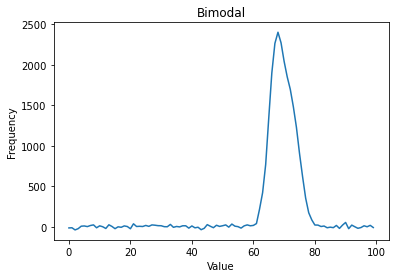

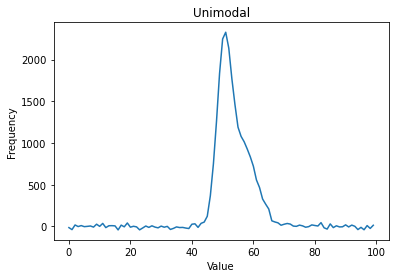

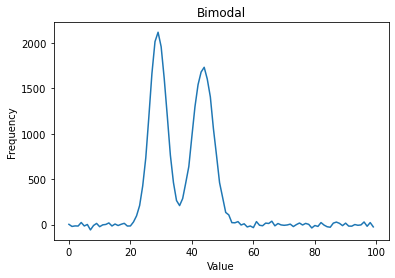

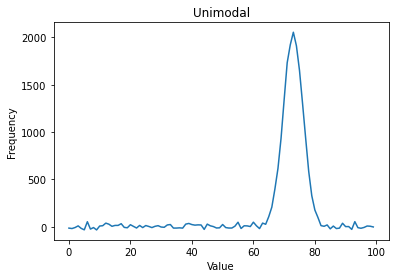

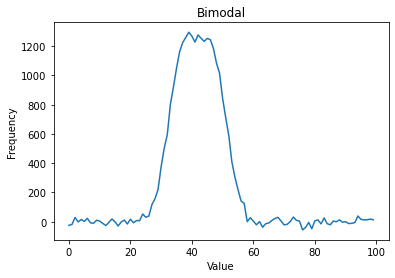

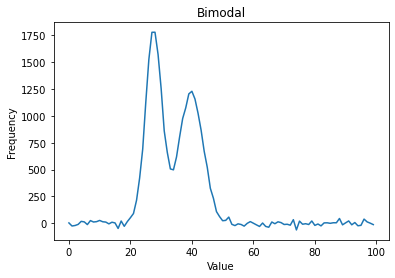

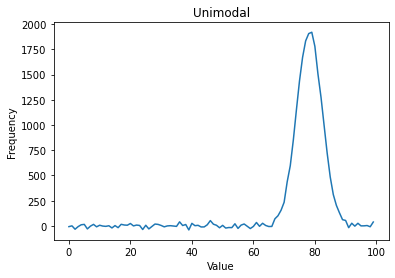

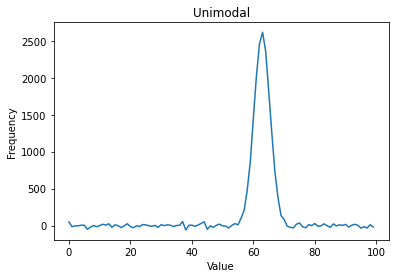

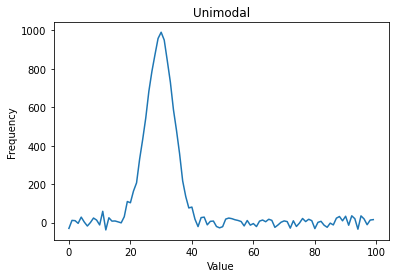

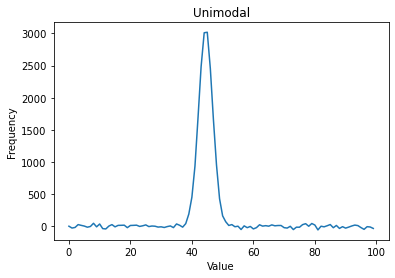

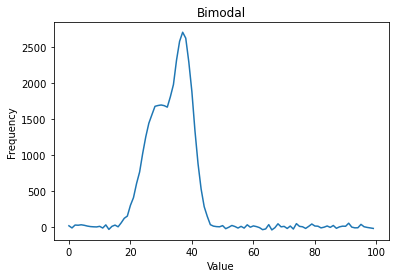

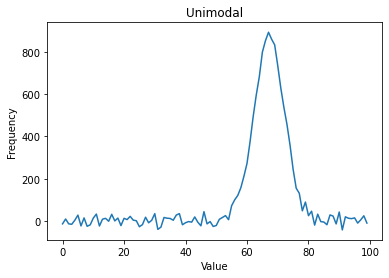

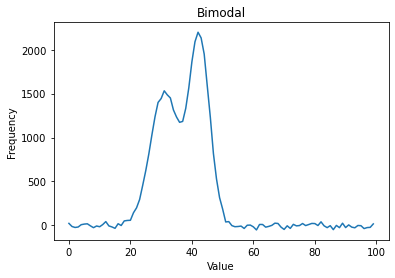

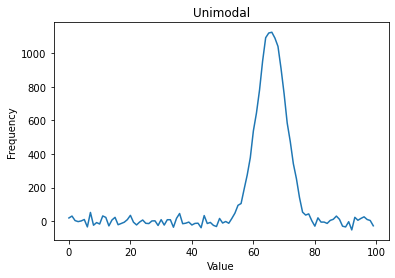

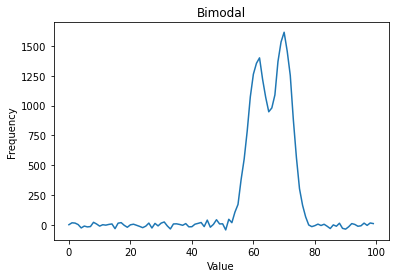

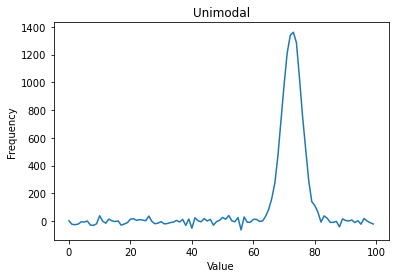

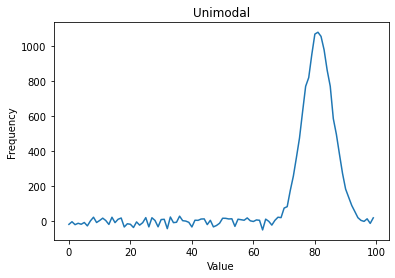

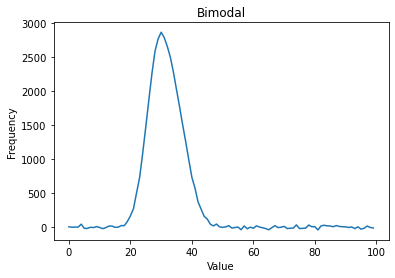

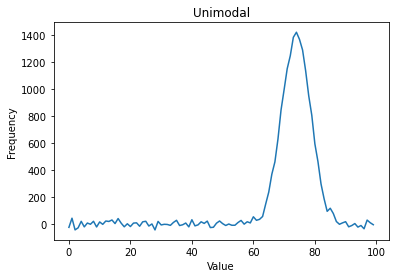

In [33]:
for i in range(len(predicted_labels)):
    plt.plot(range(len(data_real[i])), data_real[i].flatten())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    if predicted_labels[i] == 0:
        plt.title('Unimodal')
    elif predicted_labels[i] == 1:
        plt.title('Skewed')
    elif predicted_labels[i] == 2:
        plt.title('Bimodal')
    else:
        plt.title('idk man')
    
    plt.show()